In [ ]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt

def create_dataset_torch(
    dataset_name, 
    dataset_dir, 
    batch_size=64, 
    test_size=0.2, 
    random_state=42
):
    if dataset_name == 'CIFAR10':
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        dataset = torchvision.datasets.CIFAR10(root=dataset_dir, train=True, 
                                              download=True, transform=transform)
    elif dataset_name == 'MNIST':
        mean = [0.1307]
        std = [0.3081]
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        dataset = torchvision.datasets.MNIST(root=dataset_dir, train=True,
                                            download=True, transform=transform)
    else:
        raise ValueError(f"DataSet Not Supported: {dataset_name}")
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           shuffle=True, drop_last=True)
    
    images, labels = next(iter(dataloader))
    
    images = images.reshape(batch_size, -1).numpy()
    labels = labels.numpy()
    
    # 分割训练集(8)和测试集(2)
    X_train, X_test, Y_train, Y_test = train_test_split(
        images, labels, test_size=test_size, random_state=random_state
    )

    print(f"The {dataset_name} X_train size is: {X_train.shape}")
    print(f"The {dataset_name} X_test size is: {X_test.shape}")
    print(f"The {dataset_name} Y_train size is: {Y_train.shape}")
    print(f"The {dataset_name} Y_test size is: {Y_test.shape}")

    return X_train, X_test, Y_train, Y_test

In [2]:
def visualize(X, y, y_pred, title=None):

    pca = PCA(n_components=2)
    X_dim_reduction = pca.fit_transform(X)
    plt.figure(figsize=(10, 12))

    def get_color(y):
        color_dict = {-1: '#FFFFFF', 0: '#FF0000', 1: '#FFA500', 2: '#FFFF00', 3: '#008000', 
                      4: '#FF00FF', 5: '#0000FF', 6: '#00FFFF', 7: '#A52A2A', 8: '#800080', 
                      9: '#7FFFD4'}

        color = []
        for i in range(y.shape[0]):
            color.append(color_dict.get(y[i].item(), 'olive'))
        return color
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].set_title('Original Data')
    axs[0].scatter(X_dim_reduction[:, 0], X_dim_reduction[:, 1], c=get_color(y), edgecolors='black')

    axs[1].set_title('Cluster Result')
    axs[1].scatter(X_dim_reduction[:, 0], X_dim_reduction[:, 1], c=get_color(y_pred), edgecolors='black')

    plt.show()

In [3]:
class MyKMeans:
    """My Handmade KMeans Implementation"""
    def __init__(self, n_clusters=8, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.labels_ = None
        self.cluster_centers_ = None
        self.inertia_ = None
        self.n_iter_ = 0

    def _init_centroids(self, X):
        np.random.seed(self.random_state)
        idx = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[idx]

    def fit(self, X):
        n_samples, n_features = X.shape
        self.cluster_centers_ = self._init_centroids(X)
        prev_inertia = float('inf')

        for i in range(self.max_iter):
            distances = np.zeros((n_samples, self.n_clusters))
            for j in range(self.n_clusters):
                # 计算每个样本到每个聚类中心的距离
                distances[:, j] = np.sum((X - self.cluster_centers_[j])**2, axis=1)

            self.labels_ = np.argmin(distances, axis=1)

            # 更新聚类中心
            new_centroids = np.zeros((self.n_clusters, n_features))
            for j in range(self.n_clusters):
                if np.sum(self.labels_ == j) > 0:
                    new_centroids[j] = np.mean(X[self.labels_ == j], axis=0)
                else:
                    # 如果没有点分配给该聚类，随机初始化
                    new_centroids[j] = X[np.random.choice(n_samples)]

            # 计算中心点的移动距离
            self.cluster_centers_ = new_centroids

            # 计算当前的惯性(inertia)，即所有点到其聚类中心的距离平方和
            inertia = 0
            for j in range(self.n_clusters):
                cluster_points = X[self.labels_ == j]
                if len(cluster_points) > 0:
                    inertia += np.sum((cluster_points - self.cluster_centers_[j])**2)

            self.inertia_ = inertia
            self.n_iter_ += 1

            # 检查收敛条件
            if abs(prev_inertia - inertia) < self.tol:
                break

            prev_inertia = inertia

        return self

In [4]:
class NoTransform:
    def __init__(self, n_components = 2):
        pass
    def fit_transform(self, x):
        return x

In [5]:
def save_numpy(X_train, X_test, Y_train, Y_test):
    np.savetxt('X_train.csv', X_train, delimiter=',')
    np.savetxt('X_test.csv', X_test, delimiter=',')
    np.savetxt('Y_train.csv', Y_train, delimiter=',')
    np.savetxt('Y_test.csv', Y_test, delimiter=',')

def load_numpy():
    X_train = np.loadtxt('X_train.csv', delimiter=',')
    X_test = np.loadtxt('X_test.csv', delimiter=',')
    Y_train = np.loadtxt('Y_train.csv', delimiter=',')
    Y_test = np.loadtxt('Y_test.csv', delimiter=',')
    return X_train, X_test, Y_train, Y_test

In [6]:
X_train, X_test, Y_train, Y_test = create_dataset_torch('CIFAR10', '../../datasets/cifar10/train/', batch_size=10000, test_size=0.2, random_state=42)

Files already downloaded and verified
The CIFAR10 X_train size is: (8000, 3072)
The CIFAR10 X_test size is: (2000, 3072)
The CIFAR10 Y_train size is: (8000,)
The CIFAR10 Y_test size is: (2000,)


In [7]:
save_numpy(X_train, X_test, Y_train, Y_test)

In [8]:
X_train, X_test, Y_train, Y_test = load_numpy()

In [9]:
Func = {
    'KMeans': MyKMeans,
    'DBSCAN': DBSCAN,
    'AC': AgglomerativeClustering
}
Reduction = {
    'tsne': TSNE,
    'pca': PCA,
    'none': NoTransform
}

def Train_Result(func, reduction, X_train, Y_train, n_components, **kwargs):
    start_execution = time.time()
    reduction_now = Reduction[reduction](n_components = n_components)
    x_lower = reduction_now.fit_transform(X_train)
    func_now = Func[func](**kwargs)

    start_train = time.time()
    func_now.fit(x_lower)
    end_train = time.time()
    y_pred = func_now.labels_

    D = max(int(Y_train.max()), int(y_pred.max())) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(len(y_pred)):
        w[int(y_pred[i]), int(Y_train[i])] += 1
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    col_ind = np.asarray(col_ind)
    y_pred = col_ind[[y_pred[i] for i in range(len(y_pred))]]

    visualize(X_train, Y_train, y_pred, title=func)
    end_execution = time.time()

    print("Train Time: %.6f s" % (end_train - start_train))
    print("Execution Time: %.6f s" % (end_execution - start_execution))
    print('')
    print('Accuracy:', accuracy_score(Y_train, y_pred))
    print('Error Rate:', 1-accuracy_score(Y_train, y_pred))
    print('')
    print('Macro Precision_score:', precision_score(Y_train, y_pred, average='macro'))
    print('Micro Precision_score:', precision_score(Y_train, y_pred, average='micro'))
    print('Weighted Precision_score:', precision_score(Y_train, y_pred, average='weighted'))
    print('Every Precision_score:', precision_score(Y_train, y_pred, average=None))
    print('')
    print('Macro Recall_score:', recall_score(Y_train, y_pred, average='macro'))
    print('Micro Recall_score:', recall_score(Y_train, y_pred, average='micro'))
    print('Weighted Recall_score:', recall_score(Y_train, y_pred, average='weighted'))
    print('Every Recall_score:', recall_score(Y_train, y_pred, average=None))
    print('')
    print('Confusion Matrix:', confusion_matrix(Y_train, y_pred))

NameError: name 'TSNE' is not defined

<Figure size 1000x1200 with 0 Axes>

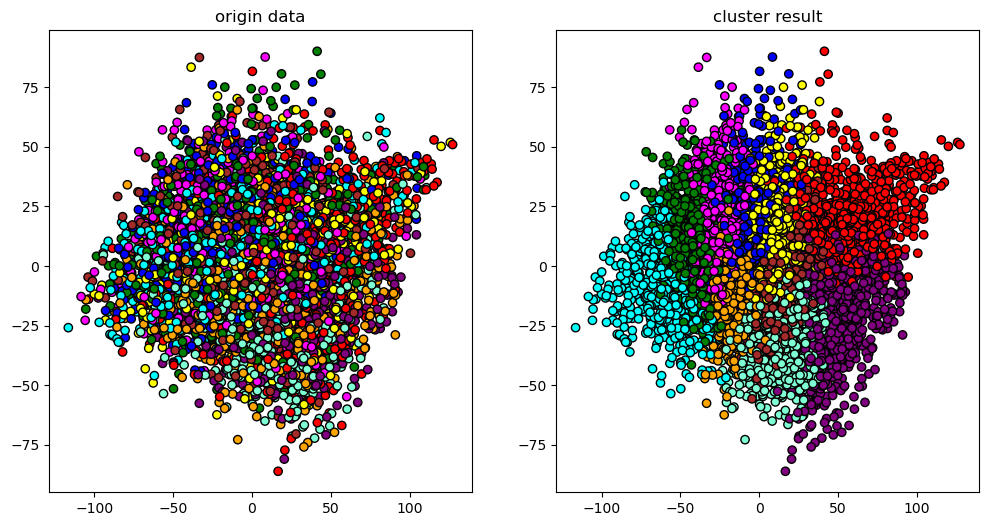

train time: 0.038852 s
execution time: 12.080682 s

acc: 0.214
error: 0.786

macro precision_score: 0.2149159416569618
micro precision_score: 0.214
weighted precision_score: 0.2151583207775102
every precision_score: [0.34411384 0.15777262 0.15393795 0.13190955 0.21320973 0.21555252
 0.2058011  0.18078382 0.27698309 0.26909518]

macro recall_score: 0.21401937041418767
micro recall_score: 0.214
weighted recall_score: 0.214
every recall_score: [0.33043478 0.17324841 0.16287879 0.125      0.24115334 0.19128329
 0.18956743 0.18644068 0.26691729 0.27326969]

confusion_matrix: [[266  59  44  27  15  71  37  63 120 103]
 [ 24 136  43 106  57  33  77  73 110 126]
 [112  92 129  61 100  79  87  70  31  31]
 [ 70  83 121 105 110 112 101  78  30  30]
 [ 40  72  93  90 184  80  93  57  25  29]
 [ 70  85 113 136 105 158  78  59  10  12]
 [ 56  97 102 117 128  45 149  60  21  11]
 [ 45  67 125  75 122  64  36 143  43  47]
 [ 61  63  24  44  11  69  21  59 213 233]
 [ 29 108  44  35  31  22  45 129 16

In [ ]:
Train_Result('KMeans', 'tsne', X_train, Y_train, n_components=1, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

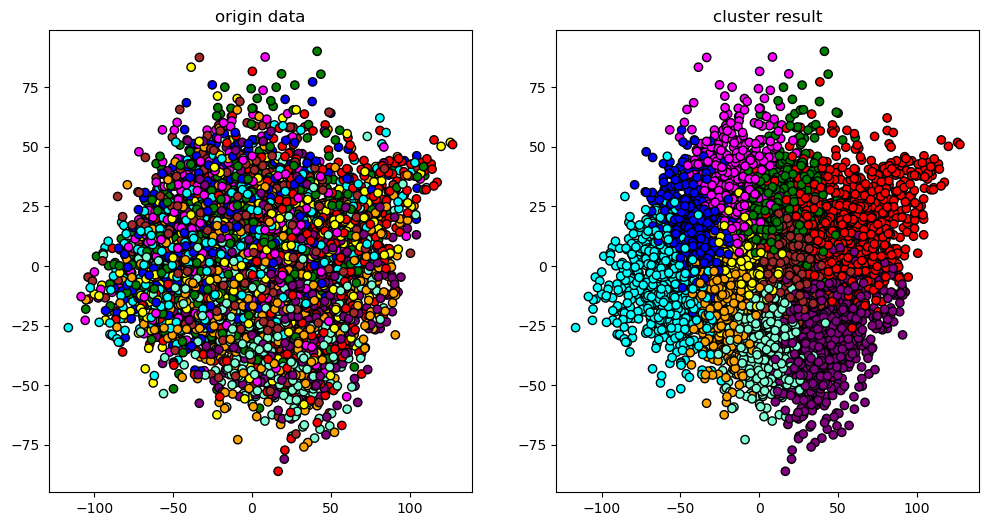

train time: 0.148158 s
execution time: 18.884780 s

acc: 0.209625
error: 0.790375

macro precision_score: 0.20393790673388498
micro precision_score: 0.209625
weighted precision_score: 0.2047704415290456
every precision_score: [0.31965443 0.13226205 0.14093137 0.1686747  0.1674277  0.16157761
 0.2118451  0.12244898 0.32315789 0.29139923]

macro recall_score: 0.20900400774015887
micro recall_score: 0.209625
weighted recall_score: 0.209625
every recall_score: [0.36770186 0.13630573 0.14520202 0.13333333 0.14416776 0.15375303
 0.23664122 0.11734029 0.38471178 0.27088305]

confusion_matrix: [[296  34  51  30  45  16  44  81 154  54]
 [ 64 107  67  34  45  79 100  50 114 125]
 [130 103 115  56  48  65 106  92  35  42]
 [ 79  68  95 112 102 116 123  73  26  46]
 [ 44  97  95  67 110 116 104  65  30  35]
 [ 68  76 115 119 120 127  91  74  11  25]
 [ 69  99 118  76  43 114 186  49  12  20]
 [ 46  92  76 107  81  92  42  90  58  83]
 [ 70  39  37  29  44  28  29  93 307 122]
 [ 60  94  47  34  1

In [ ]:
Train_Result('KMeans', 'tsne', X_train, Y_train, n_components=2, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

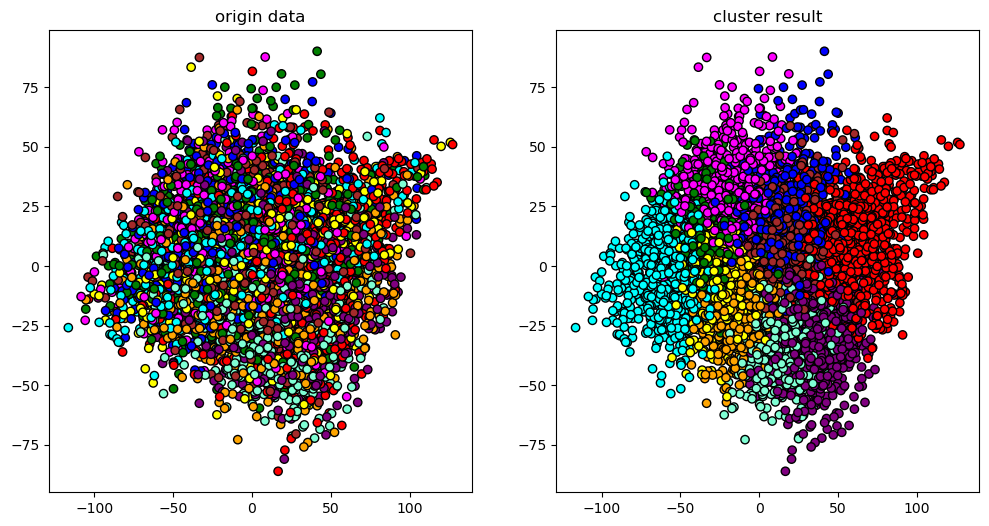

train time: 0.118022 s
execution time: 44.823634 s

acc: 0.2175
error: 0.7825

macro precision_score: 0.21879235633912675
micro precision_score: 0.2175
weighted precision_score: 0.2195206384916795
every precision_score: [0.26606539 0.17559153 0.1426799  0.1825525  0.1958042  0.18791064
 0.21929825 0.15719064 0.33814681 0.32268371]

macro recall_score: 0.2177284826296865
micro recall_score: 0.2175
weighted recall_score: 0.2175
every recall_score: [0.2931677  0.17961783 0.14520202 0.13452381 0.22018349 0.17312349
 0.25445293 0.18383312 0.35213033 0.24105012]

confusion_matrix: [[236  86  30  19  34 137  37  53 136  37]
 [ 81 141  63  61  85  34 102  56  89  73]
 [112  68 115  44  85  65 111 121  36  35]
 [ 70  51  96 113 101 102 126 117  17  47]
 [ 43  52 120  59 168  59 113  82  33  34]
 [ 48  52  79 150 111 143 103 107  14  19]
 [ 76  53 139  72  76  29 200 114   5  22]
 [ 51  46  93  56 130  59  47 141  47  97]
 [102 127  10  26  31  97  23  41 281  60]
 [ 68 127  61  19  37  36  50  

In [ ]:
Train_Result('KMeans', 'tsne', X_train, Y_train, n_components=3, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

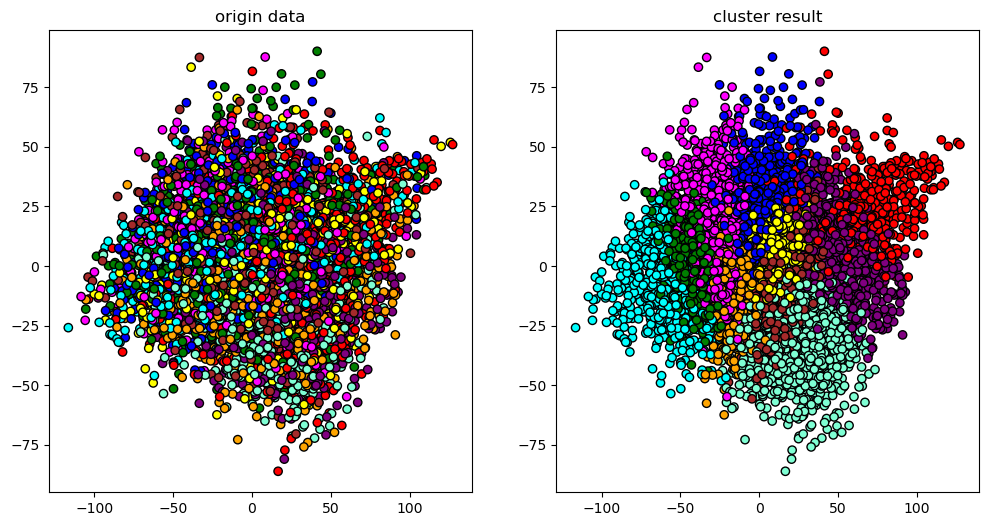

train time: 1.292773 s
execution time: 19.627554 s

acc: 0.207875
error: 0.792125

macro precision_score: 0.21431864593736422
micro precision_score: 0.207875
weighted precision_score: 0.21463418785695493
every precision_score: [0.4610245  0.15965347 0.17331288 0.12808642 0.1922754  0.20581655
 0.20524017 0.17819149 0.18276374 0.25682183]

macro recall_score: 0.20759445867609655
micro recall_score: 0.207875
weighted recall_score: 0.207875
every recall_score: [0.25714286 0.16433121 0.14267677 0.09880952 0.30013106 0.22276029
 0.17938931 0.17470665 0.15413534 0.38186158]

confusion_matrix: [[207  57  33  27  27  84  33  56 108 173]
 [ 18 129  20  98  82  53  69  75  79 162]
 [ 66  97 113  54 123  83  87  61  62  46]
 [ 30  75  88  83 157 138  98  73  61  37]
 [ 12  77  73  55 229  91  93  53  38  42]
 [ 24  79  87 103 158 184  72  52  50  17]
 [ 37  81  90 104 176  54 141  52  36  15]
 [ 17  56 101  45 166  96  36 134  40  76]
 [ 23  68  17  39  21  75  17  57 123 358]
 [ 15  89  30  40  

In [ ]:
Train_Result('AC', 'tsne', X_train, Y_train, n_components=1, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

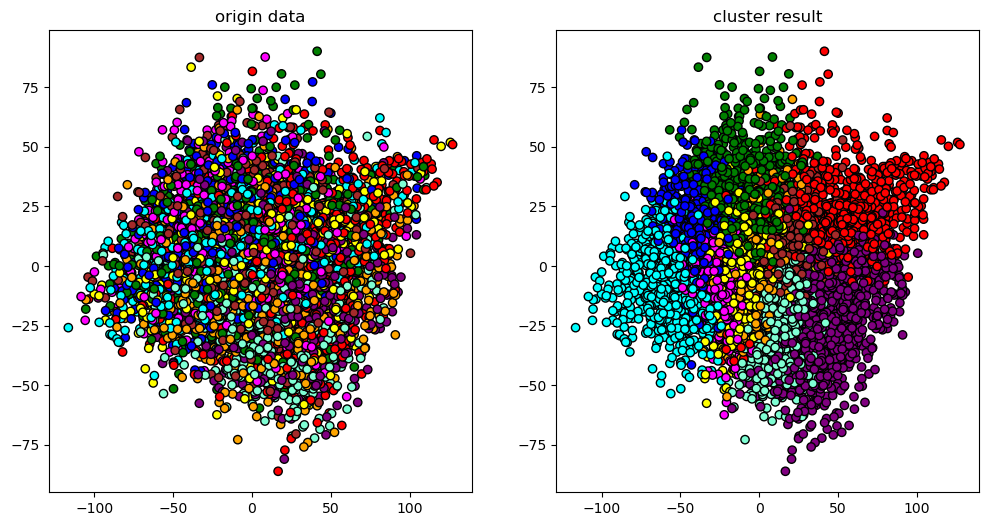

train time: 1.240885 s
execution time: 26.998289 s

acc: 0.215125
error: 0.784875

macro precision_score: 0.2056047516706745
micro precision_score: 0.215125
weighted precision_score: 0.20643761977252692
every precision_score: [0.35562988 0.08       0.13980583 0.15777262 0.16510067 0.21769912
 0.20129171 0.16536661 0.30431034 0.26907074]

macro recall_score: 0.21459460245427503
micro recall_score: 0.215125
weighted recall_score: 0.215125
every recall_score: [0.39627329 0.04585987 0.18181818 0.16190476 0.16120577 0.14891041
 0.23791349 0.13820078 0.44235589 0.23150358]

confusion_matrix: [[319  19  66  36  17  17  42  55 177  57]
 [ 41  36 124  72  68  57 107  43 152  85]
 [128  32 144  64 100  38 116  76  45  49]
 [ 76  72 106 136  85  82 125  68  44  46]
 [ 47  29 121 136 123  62 111  50  35  49]
 [ 67  86 124 143  60 123 105  72  17  29]
 [ 49  42 117  63 134  69 187  79  30  16]
 [ 42  49  79 118  90  69  43 106  72  99]
 [ 86  29  81  45   8  32  30  37 353  97]
 [ 42  56  68  49  6

In [ ]:
Train_Result('AC', 'tsne', X_train, Y_train, n_components=2, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

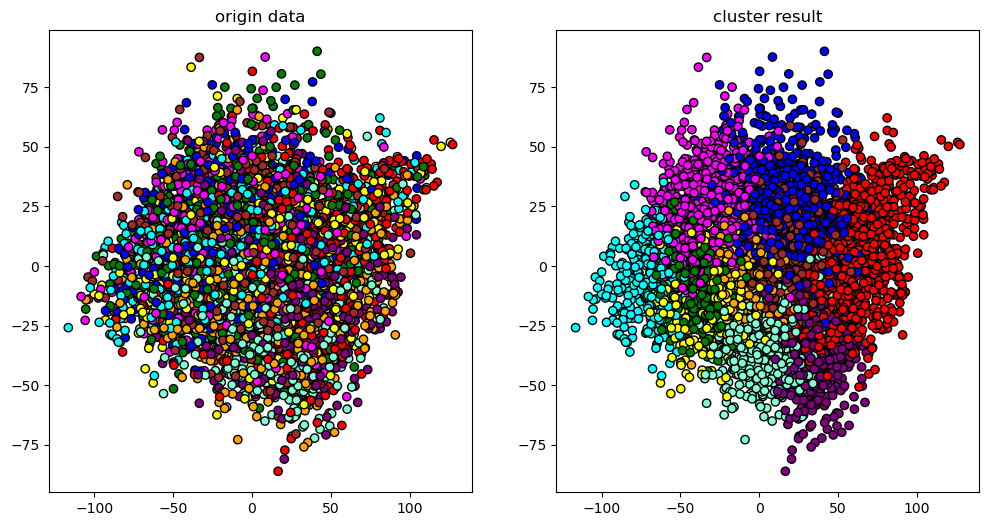

train time: 1.349984 s
execution time: 56.889804 s

acc: 0.20325
error: 0.7967500000000001

macro precision_score: 0.2047761424376297
micro precision_score: 0.20325
weighted precision_score: 0.2050682331269169
every precision_score: [0.2449187  0.16436252 0.13991163 0.11744387 0.19641577 0.17718237
 0.22081218 0.1509901  0.33559322 0.30013106]

macro recall_score: 0.20350175819665783
micro recall_score: 0.20325
weighted recall_score: 0.20325
every recall_score: [0.29937888 0.13630573 0.11994949 0.08095238 0.35910878 0.24818402
 0.11068702 0.15906128 0.2481203  0.27326969]

confusion_matrix: [[241  88  25  29  26 183  15  42 107  49]
 [ 99 107  49  97 113  40  40  65  66 109]
 [ 90  56  95  57 153 127  47 107  22  38]
 [ 62  36  96  68 198 157  59 105  12  47]
 [ 35  49  79  34 274 112  49  78  19  34]
 [ 41  78  67  87 190 205  44  93   6  15]
 [ 65  54 108  90 190  69  87 108   1  14]
 [ 46  42  80  34 167 114  23 122  35 104]
 [183  74  13  36  36 101   8  25 198 124]
 [122  67  67  

In [ ]:
Train_Result('AC', 'tsne', X_train, Y_train, n_components=3, n_clusters=10)